### Libraries and Modules

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io, restoration, filters#, feature
from PIL import Image
from ipywidgets import interact, widgets


# Modules
from RICM_VESICLE import RICM
from FITTING import Fit_Gaussian

# Functions
def avg_movie(movie, l=2, show_dim=True):
    
    # Average each l frames
    movie_consecutive = []
    for i in range(int(movie.shape[0]/l)):
        movie_consecutive.append(np.mean(movie[l*i:l*i+(l-1)], axis=0))

    # Transform the movie into numpy array
    movie_consecutive = np.array(movie_consecutive)
    
    # Show the dimension reduction
    if show_dim == True:
        print("{} --> {}".format(movie.shape, movie_consecutive.shape))
    
    return movie_consecutive

### Read the whole RICM image to determine the base line

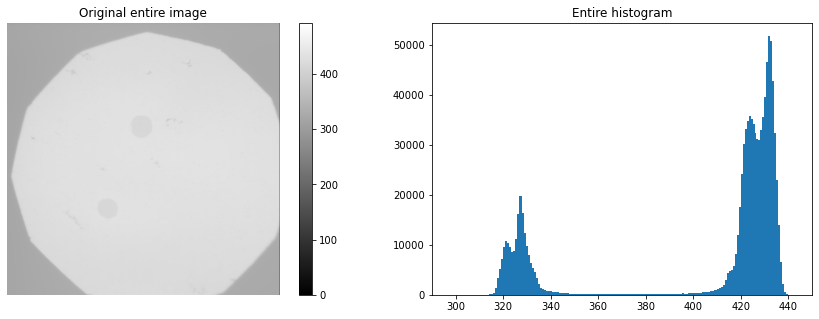

In [2]:
# Determine the Shot and the GUV
shot, guv = 4, 2

# Read the RICM image
RICM_img = io.imread("20201216_Ecad_dynamics/data/Calib_camera{}.tif".format(shot)).mean(axis=0)

#RICM_img = np.mean(RICM_img, axis=0)

# display the image and it's histogram
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original entire image')
plt.imshow(RICM_img, cmap = "gray")
plt.colorbar()

plt.subplot(122)
plt.title('Entire histogram')
plt.hist(RICM_img.ravel(), bins = 600);
plt.xlim(290,450);

### Read the GUV image and subtract the base line

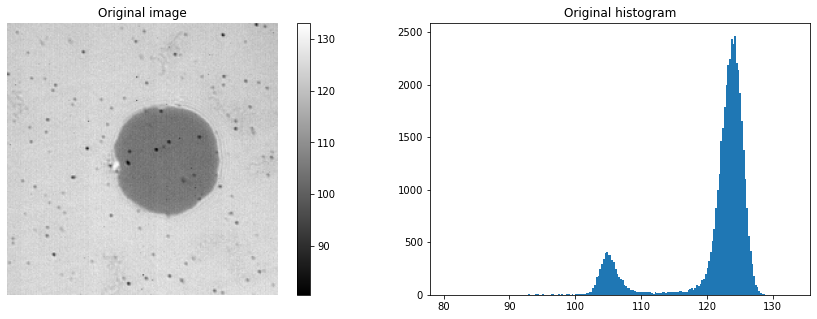

In [3]:
# Read the image
guv = io.imread("20201216_Ecad_dynamics/data/Calib_camera{}-{}.tif".format(shot, guv))

# Subtract the base line
guv = guv - 310

# Take the mean
img = guv.mean(axis=0)

# display the image and it's histogram
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original image')
plt.imshow(img, cmap = "gray")
plt.colorbar();

plt.subplot(122)
plt.title('Original histogram')
plt.hist(img.ravel(), bins = 200);
#plt.xlim(70,87)

(200, 209, 208) --> (33, 209, 208)


<Figure size 1080x360 with 0 Axes>

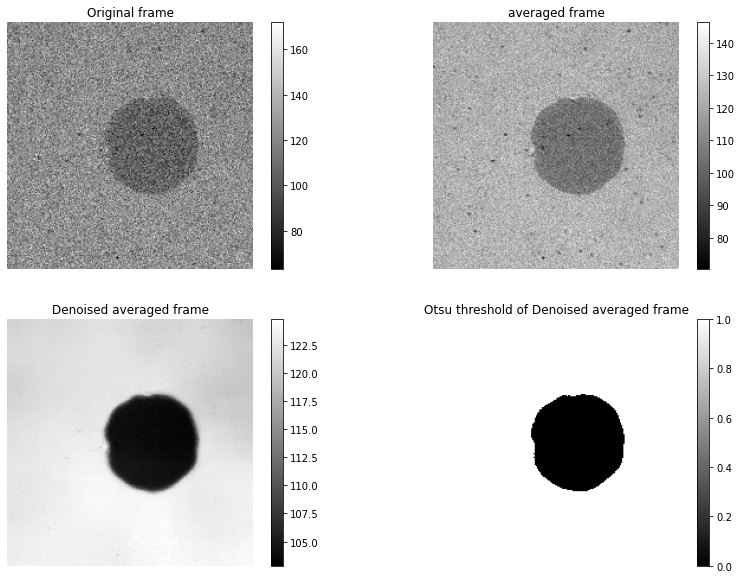

In [4]:
frame, L = 0, 6

# Take a cosecutive average of the movie
guv_consecutive = avg_movie(guv, l=L)

#Estimating the noise variance of the image
sigma_est = np.mean(restoration.estimate_sigma(guv_consecutive[0] , multichannel = False))

#Apply the Non-local means denoising algorithm
img_denoised = restoration.denoise_nl_means(guv_consecutive[frame], h = sigma_est,fast_mode = True,
                                            patch_size = 10,
                                            patch_distance = 20,
                                            multichannel = False)
# display the denoised image and it's histogram
plt.figure(figsize=(15,5))

# display the image and it's histogram
plt.figure(figsize=(14,10))

plt.subplot(221)
plt.axis('off')
plt.title('Original frame')
plt.imshow(guv[frame*L], cmap = "gray")
plt.colorbar()

plt.subplot(222)
plt.axis('off')
plt.title('averaged frame')
plt.imshow(guv_consecutive[frame], cmap = "gray")
plt.colorbar()
    
plt.subplot(223)
plt.axis('off')
plt.title('Denoised averaged frame')
plt.imshow(img_denoised, cmap = 'gray')
plt.colorbar()
    
plt.subplot(224)
plt.axis('off')
plt.title('Otsu threshold of Denoised averaged frame')
plt.imshow(np.multiply(img_denoised > filters.threshold_otsu(img_denoised), 1), cmap = 'gray')
plt.colorbar();

In [5]:
L = 6

# Take a cosecutive average of the movie
guv_consecutive = avg_movie(guv, l=L)

#Estimating the noise variance of the image
sigma_est = np.mean(restoration.estimate_sigma(guv_consecutive[0] , multichannel = False))

area = []
for i in range(guv_consecutive.shape[0]):

    #Apply the Non-local means denoising algorithm
    img_denoised = restoration.denoise_nl_means(guv_consecutive[i], h = sigma_est,fast_mode = True,
                                                patch_size = 10,
                                                patch_distance = 20,
                                                multichannel = False)
    
    area.append((1 - np.multiply(img_denoised > filters.threshold_otsu(img_denoised), 1)).sum())
    
area = np.array(area)

(200, 209, 208) --> (33, 209, 208)


Text(0, 0.5, 'Area')

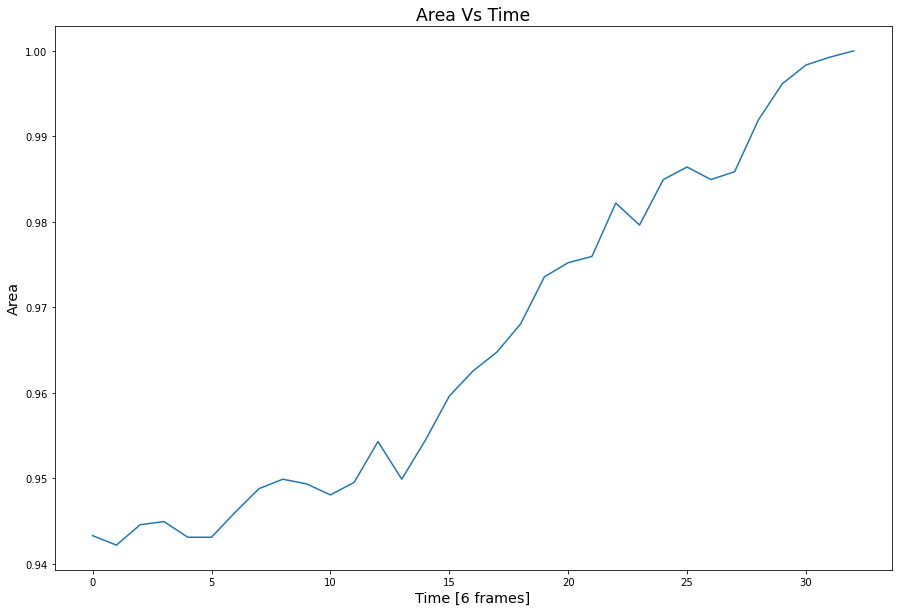

In [23]:
area = area/area.max()

plt.figure(figsize=(15, 10))
plt.plot(area)
plt.title('Area Vs Time', fontsize= 'xx-large')
plt.xlabel('Time [6 frames]', fontsize= 'x-large')
plt.ylabel('Area', fontsize= 'x-large')


In [7]:
def consecutive_viewer(frame, L):
    
    # Take a cosecutive average of the movie
    guv_consecutive = avg_movie(guv, l=L)

    #Estimating the noise variance of the image
    sigma_est = np.mean(restoration.estimate_sigma(guv_consecutive[0] , multichannel = False))

    #Apply the Non-local means denoising algorithm
    img_denoised = restoration.denoise_nl_means(guv_consecutive[frame], h = sigma_est,fast_mode = True,
                                                patch_size = 10,
                                                patch_distance = 20,
                                                multichannel = False)
    # display the denoised image and it's histogram
    plt.figure(figsize=(15,5))

    # display the image and it's histogram
    plt.figure(figsize=(14,10))

    plt.subplot(221)
    plt.axis('off')
    plt.title('Original frame')
    plt.imshow(guv[frame*L], cmap = "gray")
    plt.colorbar()

    plt.subplot(222)
    plt.axis('off')
    plt.title('averaged frame')
    plt.imshow(guv_consecutive[frame], cmap = "gray")
    plt.colorbar()
    
    plt.subplot(223)
    plt.axis('off')
    plt.title('Denoised image')
    plt.imshow(img_denoised, cmap = 'gray')
    plt.colorbar()
    
    plt.subplot(224)
    plt.axis('off')
    plt.title('Otsu threshold of Denoised')
    plt.imshow(np.multiply(img_denoised > filters.threshold_otsu(img_denoised), 1), cmap = 'gray');

    
interact(consecutive_viewer,
         L = np.arange(2, int(guv.shape[0]/2), dtype = int),
         #L = widgets.IntSlider(value= 6, min=1, max=guv.shape[0], continuous_update=False),
         frame = widgets.IntSlider(value= 0, min=0, max=guv_consecutive.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='frame', max=32), Dropdown(descr…

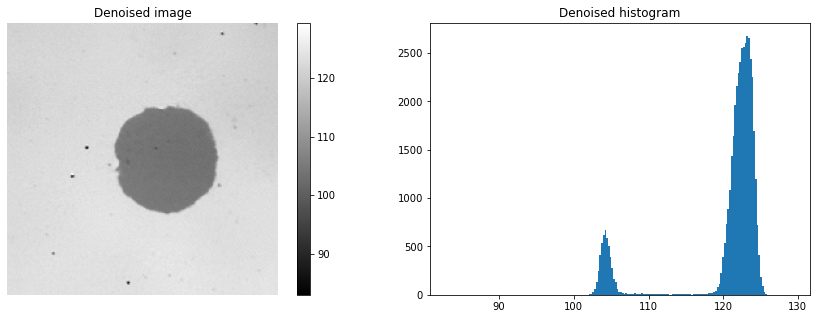

In [8]:
#Estimating the noise variance of the image
sigma_est = np.mean(restoration.estimate_sigma(guv_consecutive[0] , multichannel = False))

#Apply the Non-local means denoising algorithm
img_denoised = restoration.denoise_nl_means(guv_consecutive[0], h = sigma_est,fast_mode = True,
                                            patch_size = 5,
                                            patch_distance = 20,
                                            multichannel = False)
# display the denoised image and it's histogram
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.axis('off')
plt.title('Denoised image')
plt.imshow(img_denoised, cmap = 'gray')
plt.colorbar();

plt.subplot(122)
plt.title('Denoised histogram')
plt.hist(img_denoised.ravel(), bins = 200);

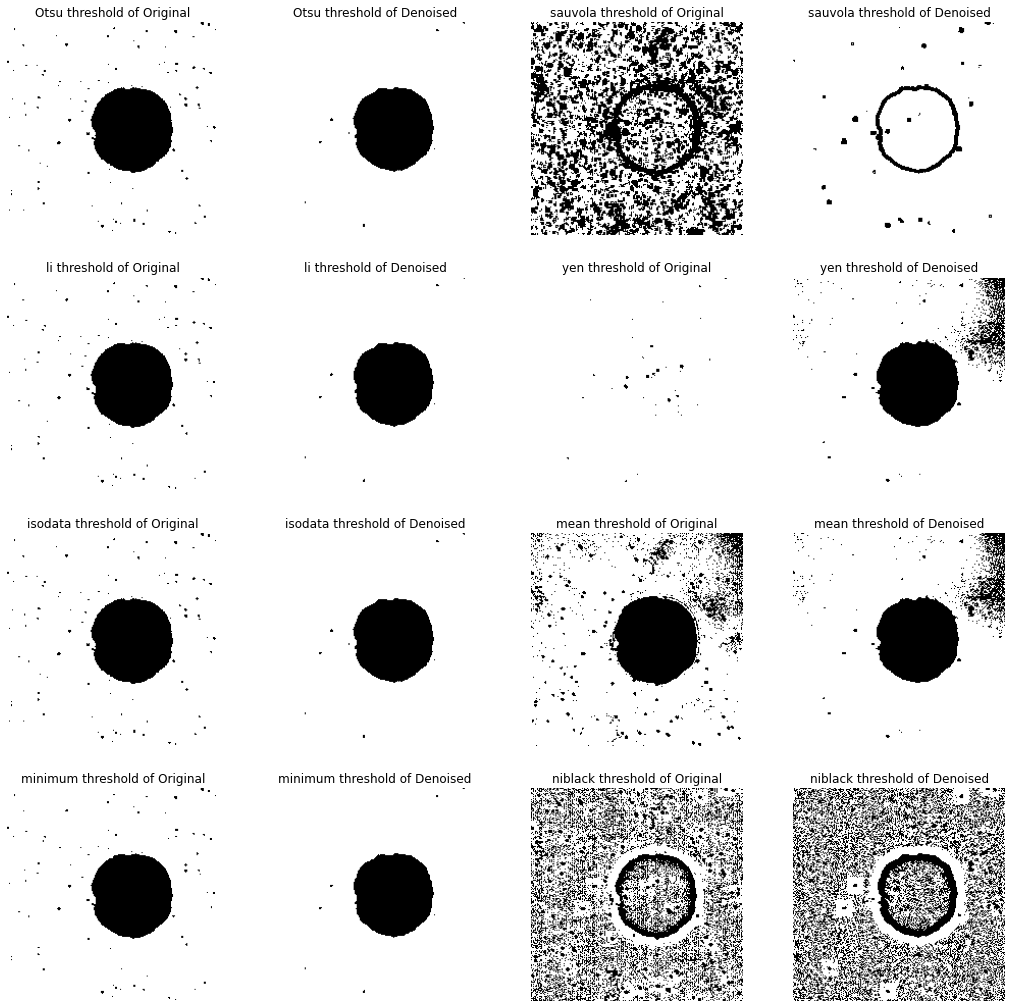

In [9]:
# Thresholds of the original image
img_threshold_otsu = filters.threshold_otsu(img)
img_threshold_sauvola = filters.threshold_sauvola(img, window_size=3)
img_threshold_li = filters.threshold_li(img)
img_threshold_yen = filters.threshold_yen(img)
img_threshold_isodata = filters.threshold_isodata(img)
img_threshold_mean = filters.threshold_mean(img)
img_threshold_minimum = filters.threshold_minimum(img)
img_threshold_niblack = filters.threshold_niblack(img)


# Thresholds of the Denoised image
img_threshold_otsu_denoised = filters.threshold_otsu(img_denoised)
img_threshold_sauvola_denoised = filters.threshold_sauvola(img_denoised, window_size=3)
img_threshold_li_denoised = filters.threshold_li(img_denoised)
img_threshold_yen_denoised = filters.threshold_yen(img_denoised)
img_threshold_isodata_denoised = filters.threshold_isodata(img_denoised)
img_threshold_mean_denoised = filters.threshold_mean(img_denoised)
img_threshold_minimum_denoised = filters.threshold_minimum(img_denoised)
img_threshold_niblack_denoised = filters.threshold_niblack(img_denoised)

# display results
plt.figure(figsize=(18,18))

plt.subplot(441)
plt.axis('off')
plt.title('Otsu threshold of Original')
plt.imshow(img > img_threshold_otsu, cmap = 'gray')

plt.subplot(442)
plt.axis('off')
plt.title('Otsu threshold of Denoised')
plt.imshow(img_denoised > img_threshold_otsu_denoised, cmap = 'gray')

plt.subplot(443)
plt.axis('off')
plt.title('sauvola threshold of Original')
plt.imshow(img > img_threshold_sauvola, cmap = 'gray')

plt.subplot(444)
plt.axis('off')
plt.title('sauvola threshold of Denoised')
plt.imshow(img_denoised > img_threshold_sauvola_denoised, cmap = 'gray')

plt.subplot(445)
plt.axis('off')
plt.title('li threshold of Original')
plt.imshow(img > img_threshold_li, cmap = 'gray')

plt.subplot(446)
plt.axis('off')
plt.title('li threshold of Denoised')
plt.imshow(img_denoised > img_threshold_li_denoised, cmap = 'gray')

plt.subplot(447)
plt.axis('off')
plt.title('yen threshold of Original')
plt.imshow(img > img_threshold_yen, cmap = 'gray')

plt.subplot(448)
plt.axis('off')
plt.title('yen threshold of Denoised')
plt.imshow(img_denoised > img_threshold_yen_denoised, cmap = 'gray')

plt.subplot(449)
plt.axis('off')
plt.title('isodata threshold of Original')
plt.imshow(img > img_threshold_isodata, cmap = 'gray')

plt.subplot(4,4,10)
plt.axis('off')
plt.title('isodata threshold of Denoised')
plt.imshow(img_denoised > img_threshold_isodata_denoised, cmap = 'gray')

plt.subplot(4,4,11)
plt.axis('off')
plt.title('mean threshold of Original')
plt.imshow(img > img_threshold_mean, cmap = 'gray')

plt.subplot(4,4,12)
plt.axis('off')
plt.title('mean threshold of Denoised')
plt.imshow(img_denoised > img_threshold_mean_denoised, cmap = 'gray')

plt.subplot(4,4,13)
plt.axis('off')
plt.title('minimum threshold of Original')
plt.imshow(img > img_threshold_minimum, cmap = 'gray')

plt.subplot(4,4,14)
plt.axis('off')
plt.title('minimum threshold of Denoised')
plt.imshow(img_denoised > img_threshold_minimum_denoised, cmap = 'gray')

plt.subplot(4,4,15)
plt.axis('off')
plt.title('niblack threshold of Original')
plt.imshow(img > img_threshold_niblack, cmap = 'gray')

plt.subplot(4,4,16)
plt.axis('off')
plt.title('niblack threshold of Denoised')
plt.imshow(img_denoised > img_threshold_niblack_denoised, cmap = 'gray');

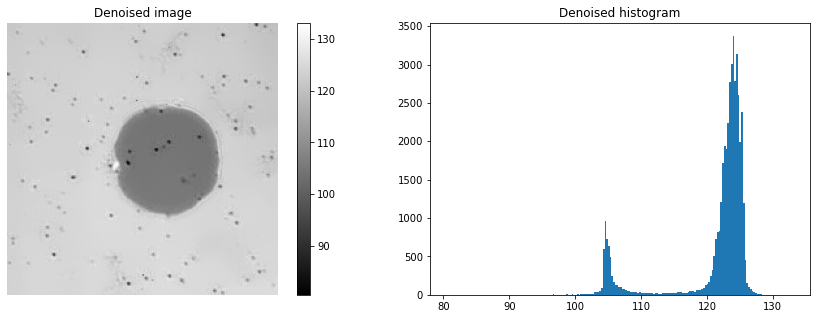

In [10]:
#Estimating the noise variance of the image
sigma_est = np.mean(restoration.estimate_sigma(img , multichannel = False))

#Apply the Non-local means denoising algorithm
img_denoised = restoration.denoise_nl_means(img, h = sigma_est,fast_mode = True,
                                            patch_size = 10,
                                            patch_distance = 10,
                                            multichannel = False)
# display the denoised image and it's histogram
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.axis('off')
plt.title('Denoised image')
plt.imshow(img_denoised, cmap = 'gray')
plt.colorbar();

plt.subplot(122)
plt.title('Denoised histogram')
plt.hist(img_denoised.ravel(), bins = 200);

In [11]:
def image_threshold(Lower_threshold, Upper_threshold):
    
    masked_img = cv2.inRange(img, Lower_threshold, Upper_threshold)
    masked_img_denoised = cv2.inRange(img_denoised, Lower_threshold, Upper_threshold)

    plt.figure(figsize=(18,5))

    plt.subplot(121)
    plt.axis('off')
    plt.title("Threshold of Original")
    plt.imshow(masked_img, cmap = 'gray')

    plt.subplot(122)
    plt.axis('off')
    plt.title("Threshold of Denoised")
    plt.imshow(masked_img_denoised, cmap = 'gray');
    
interact(image_threshold, 
         Lower_threshold = widgets.FloatSlider(value= img.min(), min=img.min(), max=img.max(),
                                               continuous_update=False),
         Upper_threshold = widgets.FloatSlider(value= img.max(), min=img.min(), max=img.max(),
                                               continuous_update=False))

interactive(children=(FloatSlider(value=80.55, continuous_update=False, description='Lower_threshold', max=133…

<function __main__.image_threshold(Lower_threshold, Upper_threshold)>

In [12]:
def image_threshold(Upper_threshold):

    plt.figure(figsize=(18,5))

    plt.subplot(121)
    plt.axis('off')
    plt.title("Threshold of Original")
    plt.imshow(img < Upper_threshold, cmap = 'gray')

    plt.subplot(122)
    plt.axis('off')
    plt.title("Threshold of Denoised")
    plt.imshow(img_denoised < Upper_threshold, cmap = 'gray');
    
interact(image_threshold, 
         Upper_threshold = widgets.FloatSlider(value= img.max(), min=img.min(), max=img.max(),
                                               continuous_update=False))

interactive(children=(FloatSlider(value=133.06, continuous_update=False, description='Upper_threshold', max=13…

<function __main__.image_threshold(Upper_threshold)>

In [13]:
import cv2
masked = cv2.inRange(np.array([[1,2],[3,4]]), 1.5, 3)
masked

array([[  0, 255],
       [255,   0]], dtype=uint8)

In [14]:
1.5 < np.array([[1,2],[3,4]]) < 3.5

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
np.arange(100)